In [2]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 29.6 MB/s 
     |████████████████████████████████| 243 kB 75.4 MB/s 


In [45]:
import nlp 
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [4]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
dataset 

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train = dataset["train"]
test = dataset["test"]
validation = dataset["validation"]

In [7]:
def get_tweets(data) : 
  tweets = data["text"]
  labels = data["label"]
  return tweets, labels

In [8]:
tweets, labels = get_tweets(train)

In [9]:
tweets[3], labels[3]

('i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'love')

In [10]:
#Converting words to numbers I am going to use most frequently used ten thousand words 
#from our corpus and anything that is not present in those most frequently
#is represented as UNK.
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>') 
tokenizer.fit_on_texts(tweets) 

In [11]:
pd.DataFrame(tweets, columns = ['tweets']).describe()

,tweets
count,16000
unique,15969
top,i am not amazing or great at photography but i...
freq,2


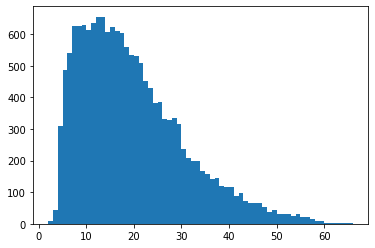

In [12]:
lengths = [ len(x.split(' ')) for x in tweets ]
plt.hist(lengths , bins = len(set(lengths)))
plt.show()

In [13]:
maxlen = 50

def get_sequences (tokenizer, tweets) :
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences (sequences, truncating = "post", padding = "post", maxlen = maxlen)
  return padded

In [14]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [15]:
padded_train_seq[3]

array([   2,   24,  165,    8,  665,   27,    6, 4158,    2,   59,   47,
          9,   13,   22,   72,   30,    6, 3497,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [16]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'anger', 'love', 'sadness', 'fear'}


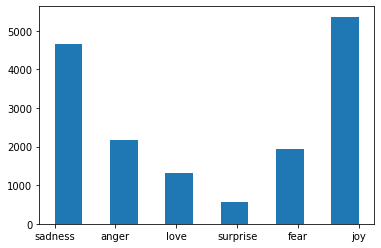

In [17]:
plt.hist(labels, bins = 11)
plt.show()

In [21]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [22]:
class_to_index

{'anger': 2, 'fear': 5, 'joy': 1, 'love': 3, 'sadness': 4, 'surprise': 0}

In [23]:
index_to_class

{0: 'surprise', 1: 'joy', 2: 'anger', 3: 'love', 4: 'sadness', 5: 'fear'}

In [25]:
names_to_ids = lambda labels  : np.array([class_to_index.get(x) for x in labels])

In [26]:
train_labels = names_to_ids(labels)

In [30]:
model = Sequential()
model.add(Embedding(10000, 16, input_length=maxlen))
model.add(Bidirectional(LSTM(20, return_sequences= True)))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(6, activation = 'softmax'))

In [31]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [34]:
val_tweets, val_labels = get_tweets(validation)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [36]:
h = model.fit( padded_train_seq, 
              train_labels, 
              validation_data = (val_seq, val_labels), 
              epochs = 20, 
              callbacks = [EarlyStopping(monitor = 'val_accuracy', patience = 2)]
              )

Epoch 1/20
500/500 [==============================] - 23s 23ms/step - loss: 1.2630 - accuracy: 0.4873 - val_loss: 0.8107 - val_accuracy: 0.6825
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.5882 - accuracy: 0.7793 - val_loss: 0.5608 - val_accuracy: 0.8050
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3360 - accuracy: 0.8889 - val_loss: 0.5217 - val_accuracy: 0.8240
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2177 - accuracy: 0.9318 - val_loss: 0.4911 - val_accuracy: 0.8550
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.1695 - accuracy: 0.9477 - val_loss: 0.4310 - val_accuracy: 0.8715
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1215 - accuracy: 0.9609 - val_loss: 0.4594 - val_accuracy: 0.8640
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1159 - accuracy: 0.9621 - val_loss: 0.4098 - val_accuracy: 0.882

In [38]:
def show_history(h):
  epochs_trained = len(h.history['loss'])
  plt.figure(figsize=(16, 6))

  plt.subplot(1, 2, 1)
  plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
  plt.ylim([0., 1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

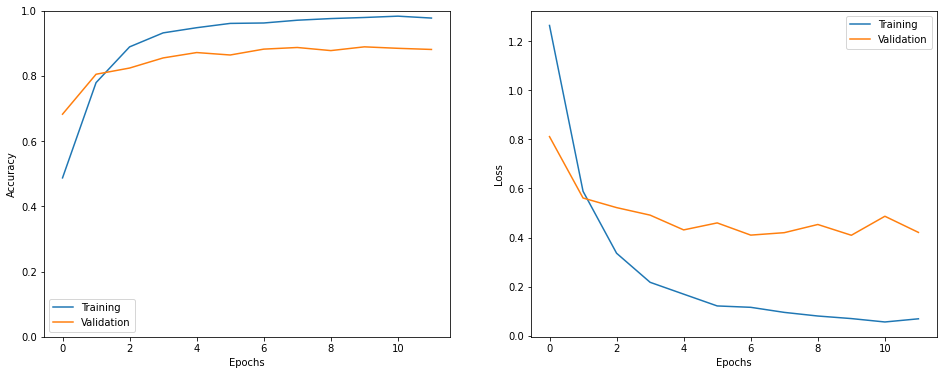

In [41]:
show_history(h)

In [43]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [44]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 10ms/step - loss: 0.4184 - accuracy: 0.8865


In [46]:
i = random.randint(0, len(test) - 1)

In [51]:
print(test_tweets[i])
print(index_to_class[test_labels[i]])

i don t always feel like i have amazing style and most days i choose comfort over anything else but there is one thing that i feel makes all the difference in how i feel about myself and that is makeup
joy


In [55]:
from operator import index
p = model.predict(np.expand_dims(test_seq[i], axis = 0 ))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
pred_class

'joy'

In [60]:
preds = np.argmax(model.predict(test_seq), axis=-1)

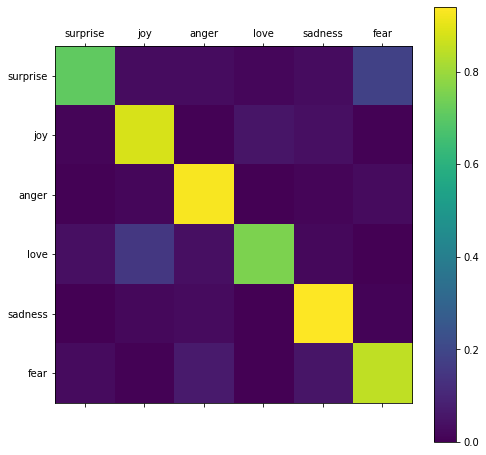

In [61]:
show_confusion_matrix(test_labels, preds, list(classes))